# 100m Windspeed Variability Tool 
In light of national goals to reach net zero emissions across all domestic economic sector activities by 2050, it is imperative to expand renewable energy development while building out the transmission infrastructure necessary to connect power generation sites with consumer demand locales. Wind power, one of the major renewable energy supplies, relies on turbines to convert wind resources into electricity through the use of rotors and generators. Given that wind power is a function of wind speed, when evaluating the predictability and consistency of wind as a renewable energy resource, it is important to understand wind speed variability across time and space. 

To that extent, I developed a prototype open-source tool to analyze hourly (60-minute interval) windspeed data at 100m above ground level from 2012 for a desired 2km radius around a lat-lon coordinate using the NREL Wind Integration National Dataset (WIND) Toolkit (WTK). This Python script utilizes the Resource eXtraction tool rex to access and extract WTK data and provides the user with the ability to create location-specific summaries and visualizations of wind speed variability across diurnal and monthly scales. Created in 2013 with funding from the Department of Energy to meet their goal of 20% domestic wind production by 2030, this WIND dataset is based on seven years of mescoscale numerical weather prediction (NWP) model output at 100m above ground level (AGL) gridded at 2km-2km resolution across the contiguous United States from 2007-2013.

### Site Selection Research Methdods
According to Mai, Lopez, Mowers & Lantz 2021, social (viewshed impact, land use conflict, political) and ecological factors (habitat fragmentation) are critical to account for in wind development. In order to maximize the likelihood of timely project implementation, land-use challenges must be considered early in the development process to ensure streamlining of siting and land acquisition. To that extent, I have consulted wind resource mapping products which account for land use exclusions as guides for selecting a study site. In accordance with siting regime analysis conducted by Mai et al. 2021, I have used the most restrictive "Limited Access" regime to pinpoint areas with high wind resources whose development potential are not obstructed by infrastructural (direct build infrastructure land use conflicts), physical (slope and terrain impacts on cost), or regulatory (various protected lands) exclusions. 



In [44]:
#Import packages for analysis
import h5pyd
import geopandas as gpd 
from rex import WindX 
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.spatial import cKDTree
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
# Make all plots inline 
%matplotlib inline

### Setup
##### Plot the target region on a continental map of the United States

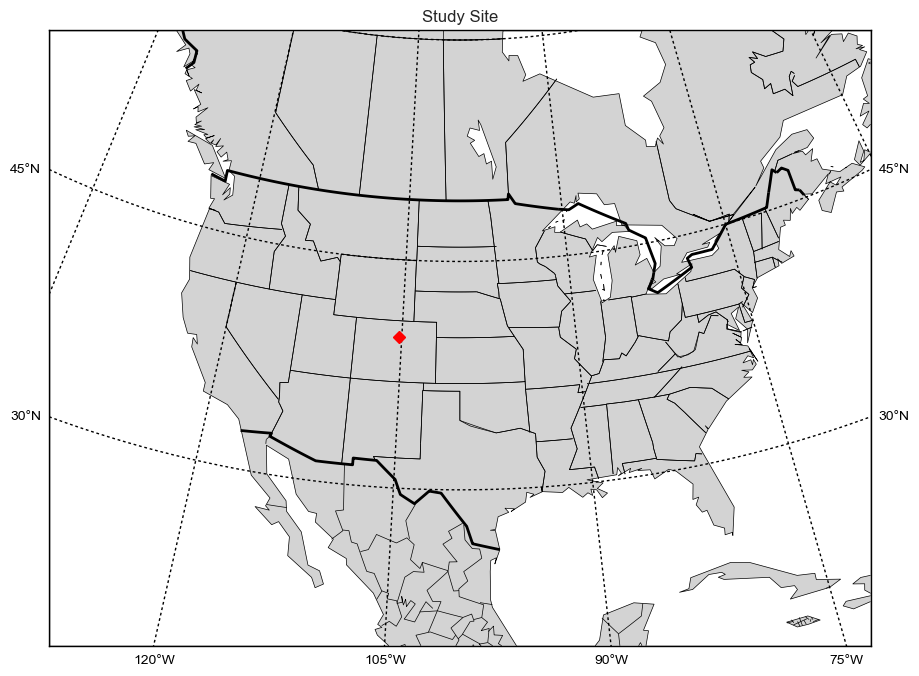

In [45]:
# Determine geographic extent (lat, lon) for 2kmx2km regional 100m wind speed analysis
lat=39.913561
lon = -105.222422
fig = plt.figure(num=None, figsize=(12, 8)) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lat_1=35.,lat_2=45,lon_0=-100,lat_0=40)
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgrey',lake_color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='white')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.plot(lon, lat, marker='D',color='r', latlon=True)
plt.title("Study Site")
plt.show()

In [52]:
from time import process_time
#Gather desired windspeed data using NREL's WindX tool to access WIND Toolkit API
#Code adapted from https://nrel.github.io/rex/misc/examples.wind.html and
# https://nrel.github.io/rex/_autosummary/rex.resource_extraction.resource_extraction.WindX.html#rex.resource_extraction.resource_extraction.WindX.get_timestep_map
wtk_file='/nrel/wtk/conus/wtk_conus_2012.h5'
#lat = '42.692909'
#lon = '103.530462'
nwtc = (39.913561, -105.222422)
# record start time
start = process_time()
with WindX(wtk_file, hsds=True) as f: 
    nwtc_wspd = f.get_lat_lon_df('windspeed_100m', nwtc)
# record end time
end = process_time()    
print('Loaded windspeed data.', "Elapsed time using process_time()", 
      (end - start), "seconds.")
nwtc_wspd

Loaded windspeed data. Elapsed time using process_time() 6.137900999999999 seconds.


,853210
time_index,
2012-01-01 00:00:00+00:00,4.35
2012-01-01 01:00:00+00:00,1.21
2012-01-01 02:00:00+00:00,4.45
2012-01-01 03:00:00+00:00,4.65
2012-01-01 04:00:00+00:00,6.75
...,...
2012-12-31 19:00:00+00:00,2.08
2012-12-31 20:00:00+00:00,1.78
2012-12-31 21:00:00+00:00,1.79


In [7]:
#Convert timezone
print('Default timezone:', nwtc_wspd.squeeze().index.tz)
# import pytz
mountain = pytz.timezone('US/Mountain')
nwtc_wspd.index = nwtc_wspd.index.tz_convert(mountain)
print('Converted timezone:', nwtc_wspd.index.tz)

Default timezone: UTC
Converted timezone: US/Mountain


In [53]:
#Extract timeseries index data to facilitate temporal analysis
summary_avg = nwtc_wspd.copy() # copy dataset to not modify original
#Assign column labels 
summary_avg['Month'] = summary_avg.index.month_name()
summary_avg['Day'] = summary_avg.index.day
summary_avg['Hour'] = summary_avg.index.hour
summary_avg = summary_avg.rename(columns={853210: 'wspd'}) # rename windspeed column to be more intuitive

#Establish seasonality
import datetime
def get_season(date: datetime.datetime, north_hemisphere: bool = True) -> str:
    now = (date.month, date.day)
    if (3, 21) <= now < (6, 21):
        season = 'Spring' if north_hemisphere else 'Autumn'
    elif (6, 21) <= now < (9, 21):
        season = 'Summer' if north_hemisphere else 'Winter'
    elif (9, 21) <= now < (12, 21):
        season = 'Autumn' if north_hemisphere else 'Spring'
    else:
        season = 'Winter' if north_hemisphere else 'Summer'

    return season
summary_avg['Season'] = summary_avg.index.map(get_season)
summary_avg.sample(5, random_state=0)

,wspd,Month,Day,Hour,Season
time_index,,,,,
2012-01-23 13:00:00+00:00,0.98,January,23,13,Winter
2012-09-21 17:00:00+00:00,1.72,September,21,17,Autumn
2012-04-17 10:00:00+00:00,13.77,April,17,10,Spring
2012-03-13 05:00:00+00:00,12.79,March,13,5,Winter
2012-12-14 12:00:00+00:00,0.39,December,14,12,Autumn


In [11]:
#Inspect temporal record post timezone conversion. Due to original data being produced in UTC, 
#this timeseries begins on Dec 31, 2011 
summary_avg.sort_index()

,wspd,Month,Day,Hour,Season
time_index,,,,,
2011-12-31 17:00:00-07:00,4.35,December,31,17,Winter
2011-12-31 18:00:00-07:00,1.21,December,31,18,Winter
2011-12-31 19:00:00-07:00,4.45,December,31,19,Winter
2011-12-31 20:00:00-07:00,4.65,December,31,20,Winter
2011-12-31 21:00:00-07:00,6.75,December,31,21,Winter
...,...,...,...,...,...
2012-12-31 12:00:00-07:00,2.08,December,31,12,Winter
2012-12-31 13:00:00-07:00,1.78,December,31,13,Winter
2012-12-31 14:00:00-07:00,1.79,December,31,14,Winter


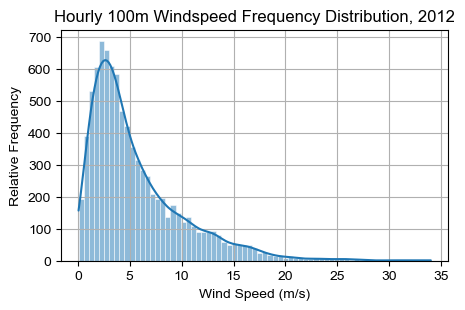

In [12]:
# Set figure size (width, height) in inches
fig, ax = plt.subplots(figsize = ( 5 , 3 ))
sns.set_style("whitegrid")
  
# Plot the scatterplot
sns.histplot( ax = ax , x = "wspd" , data = summary_avg, kde = True)
  
# Set label for x-axis
ax.set_xlabel( "Wind Speed (m/s)" , size = 10 )
  
# Set label for y-axis
ax.set_ylabel( "Relative Frequency" , size = 10 )
  
# Set title for plot
ax.set_title( "Hourly 100m Windspeed Frequency Distribution, 2012" , size = 12 )
  
# Display figure
plt.grid() 
plt.show()

##### The 2012 100m windspeed distribution based on the original hourly data is positively skewed, with the bulk of the occurrences peaking at a windspeed of 3 m/s.

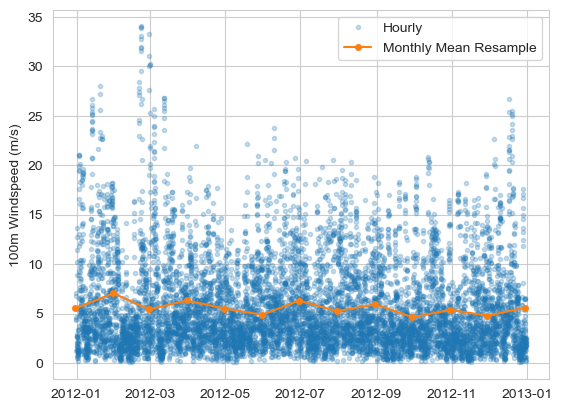

In [13]:
#Plot annual windspeed for 2012
start, end = '2011-12', '2012-12'
#aggregate monthly mean for resample
monthly_mean_wspd = summary_avg["wspd"].groupby(pd.Grouper(level=0, freq="M")).agg(["mean"])
#update column name
monthly_mean_wspd = monthly_mean_wspd.rename(columns={'mean': 'monthly_mean_wspd'}) 
#Plot w/ seaborn
fig, ax = plt.subplots()
sns.set_style("whitegrid")
ax.plot(summary_avg.loc[start:end, 'wspd'],
        marker='.', alpha = 0.25, linestyle='', linewidth=0.5, label='Hourly')
ax.plot(monthly_mean_wspd.loc[start:end, 'monthly_mean_wspd'],
marker='.', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('100m Windspeed (m/s)')
ax.legend();
#monthly_mean_wspd.loc['2012-01':'2012-12', 'monthly_mean_wspd'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(8, 7))
#mean_ax.set_ylabel('100m Windspeed (m/s^-1)');

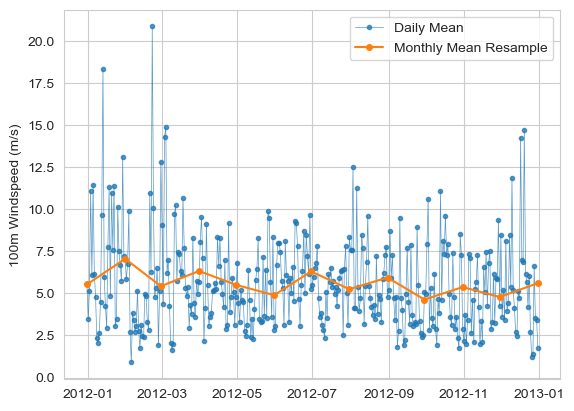

In [15]:
#Annual 100m windspeed analysis, daily mean vs. monthly mean (https://zerowithdot.com/time-series-aggregations-pandas/)
start, end = '2011-12', '2012-12'

#Compute daily means
daily_mean_wspd = summary_avg["wspd"].groupby(pd.Grouper(level=0, freq="D")).agg(["mean"])
#update column name
daily_mean_wspd = daily_mean_wspd.rename(columns={'mean': 'daily_mean_wspd'}) 
daily_mean_wspd


#Plot w/ seaborn
fig, ax = plt.subplots()
sns.set_style("whitegrid")
ax.plot(daily_mean_wspd.loc[start:end, 'daily_mean_wspd'],
        marker='.', alpha = 0.75, linestyle='-', linewidth=0.5, label='Daily Mean')
ax.plot(monthly_mean_wspd.loc[start:end, 'monthly_mean_wspd'],
marker='.', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('100m Windspeed (m/s)')
ax.legend();


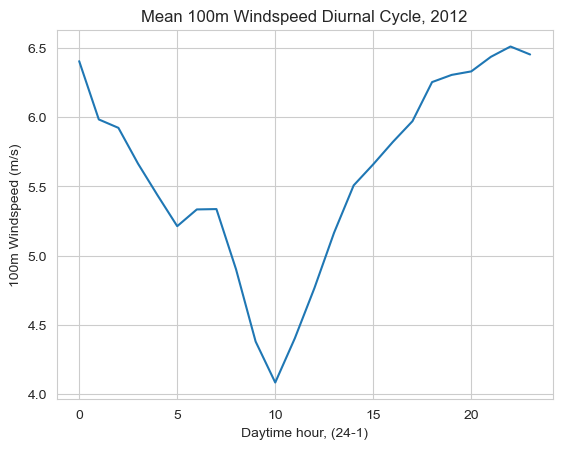

In [16]:
#Plot mean diurnal cycle 
diurnal = summary_avg.groupby('Hour')[['wspd']].mean()
diurnal
diurnal = diurnal.rename(columns={'wspd': 'mean hourly windspeed'})
#Plot 
ax = sns.lineplot(data = diurnal,
            x = 'Hour',
            y= 'mean hourly windspeed')
ax.set_ylabel('100m Windspeed (m/s)')
ax.set_xlabel('Daytime hour, (24-1)')
ax.set_title("Mean 100m Windspeed Diurnal Cycle, 2012" , size = 12 )
plt.show()

Text(0.5, 0.98, 'Seasonal Mean 100m Windspeed Diurnal Cycle, 2012')

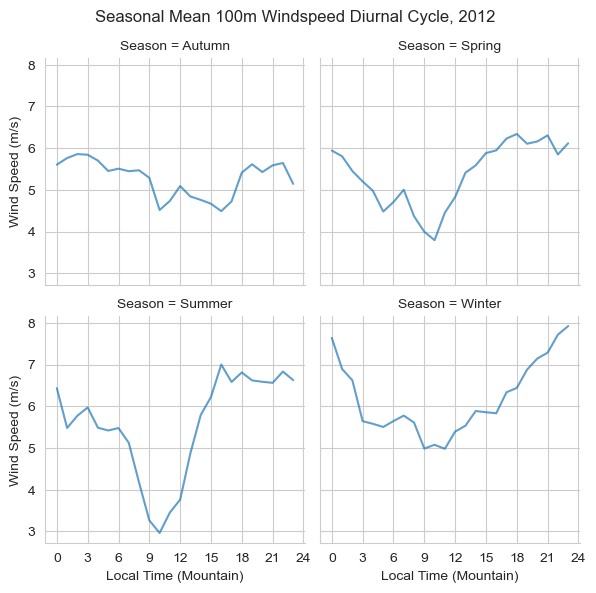

In [17]:
#Plot Seasonal Mean Diurnal Cycle of 100m windspeed
mean_seasonal = summary_avg.groupby(['Season', 'Hour']).mean().drop(columns=['Day'])
mean_seasonal = mean_seasonal.rename(columns={'wspd': 'mean seasonal wspd'}) 
mean_seasonal
g = sns.FacetGrid(mean_seasonal.reset_index(), col = 'Season', height = 3, col_wrap=2)
g.map(sns.lineplot, "Hour", "mean seasonal wspd", alpha=.7)
g.set(xticks=range(0, 25, 3))
g.set_axis_labels("Local Time (Mountain)", "Wind Speed (m/s)")
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Seasonal Mean 100m Windspeed Diurnal Cycle, 2012')

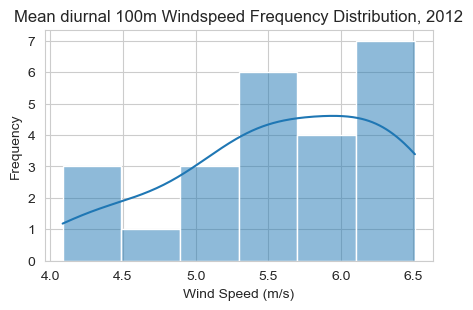

In [18]:
# Set figure size (width, height) in inches
fig, ax = plt.subplots(figsize = ( 5 , 3 ))
sns.set_style("whitegrid")
  
# Plot the scatterplot
sns.histplot( ax = ax , x = "mean hourly windspeed" , data = diurnal, kde = True)
  
# Set label for x-axis
ax.set_xlabel( "Wind Speed (m/s)" , size = 10 )
  
# Set label for y-axis
ax.set_ylabel( "Frequency" , size = 10 )
  
# Set title for plot
ax.set_title( "Mean diurnal 100m Windspeed Frequency Distribution, 2012" , size = 12 )
  
# Display figure
plt.show()